In [1]:
import numpy as np
import pandas as pd
import sys
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

import time

## Load Data

In [2]:
# load datas 
data = pd.read_csv("./chineseMNIST.csv")

In [3]:
data

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
14996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八


In [4]:
# seperate data and label
# label 
infoData  = data.iloc[: , -2:]
labelData = infoData.iloc[: , 0]
charData = infoData.iloc[: , 1]

# data 
pixelData = data.iloc[: , :-2]

## Helper function

Difference between viewdfrow() and viewrow()
- `viewdfrow()` will take a row of **panda dataframe** as input 
- `viewrow()` will take a row of **np array** as input 

Similarity between viewdfrow() and viewrow(): they both take an input with length = 4096. There is no need to pre-shape the input. 

In [5]:
def viewdfrow(pdrow):
    rowvector = pd.to_numeric(pdrow.to_numpy())
    plt.imshow(rowvector.reshape([64, 64]))

In [6]:
def viewrow(rowvector):
    plt.imshow(rowvector.reshape([64, 64]))

`labelToNum()` Method description: In this project, we need to recognize 15 characters: 0-10, bai, qian, wan, yi. When store the data, we store bai, qian, wan, yi corresponding to the label 11, 12, 13, 14   
Therefore, labelToNum() would take an label in range [0,14], and convert them into the real number that they represent 

In [7]:
def labelToNum(label):
    if label <= 10:
        return label
    elif label == 11:
        return 100
    elif label == 12:
        return 1000
    elif label == 13:
        return 10000
    elif label == 14:
        return 100000000

## Split data by character 

Our dataset is composed of 15 character: 1,2,3,4,5,6,7,8,9,10, bai, qian, wan, yi.  
We split this dataset into several subset: each subset only contains one character 

In [8]:
def splitByChar(Data, Label):
    charMap = {}
    
    for i in range(15):
        label = labelData[i*1000]
        pixels = pixelData.iloc[i*1000:(i+1)*1000, :]
        
        if(label < 11):
            charMap[label] = pixels
        elif(label == 100): # bai
            charMap[11] = pixels
        elif(label == 1000): # qian
            charMap[12] = pixels
        elif(label == 10000): # wan
            charMap[13] = pixels
        elif(label == 100000000): # yi
            charMap[14] = pixels
    
    # return charMap as result 
    return charMap

In [9]:
charMap = splitByChar(pixelData,labelData)

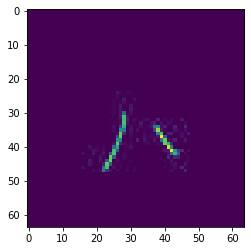

In [10]:
# test charmap split data correctly 
eightImages = charMap[8]
viewdfrow(eightImages.iloc[4])

## Split data into training and testing set 

In [11]:
testCharMap = {}
trainCharMap = {}

for i in range(15):
    train, test = train_test_split(charMap[i], test_size=0.25) 
    testCharMap[i] = test
    trainCharMap[i] = train

## Scaled the data 

In [12]:
scaledTestCharMap = {}
scaledTrainCharMap = {}


for label, image in testCharMap.items():
    scaledTestCharMap[label] = preprocessing.scale(image)

for label, image in trainCharMap.items():
    scaledTrainCharMap[label] = preprocessing.scale(image)

## Train 15 models for each character

In [13]:
tstart = time.time()

In [14]:
def PCATraining(scaledimageSet):
    pca = PCA(n_components=0.95)
    pca.fit(scaledimageSet)
    return pca

In [15]:
pcaModelList = {}
for label, image in scaledTrainCharMap.items():
    pcaModelList[label] = PCATraining(image)

## Testing function 

In [16]:
# Method description: reconstruct the testing image using 15 models 
# Input:
# - testingImage: the image that we used to reconstruct 
# 
# Output:
# - reconstruectedImage: 15 images that's being reconstructed based on 15 PCA models (in order)

def reconstructImage(scaledTestingImage):
    reconstruectedImage = {}

    for label, model in pcaModelList.items():
        lower_image = model.transform([scaledTestingImage])
        new_image = model.inverse_transform(lower_image) # can be used to view 
        reconstruectedImage[label] = new_image
    
    return reconstruectedImage

In [17]:
# Method description: plot the 15 reconstructed image 
# Input: 
# - reconstruectedImage: the result obtained from reconstructImage(), which is the 
#                        15 images that's being reconstructed based on 15 PCA models
# - sampleLabel: what number we are working on, integer, in range [0,10] OR [bai,qian,wan,yi]
# 
# Output: A Plot 
# 
def plotReconstructedImage(reconstruectedImage,sampleLabel,origionalImage):
    fig=plt.figure()
    axes=[]

    rows = 4
    cols = 4

    for i in range(rows*cols):
        if i == 0:
            currImage = origionalImage.to_numpy().reshape([64, 64])
            subplot_title=('Origional Image')

        else:
            currImage = reconstruectedImage[i-1].reshape([64, 64])
            subplot_title=("Model "+str(i))

        axes.append( fig.add_subplot(rows, cols, i+1) )
        axes[-1].set_title(subplot_title,fontsize=25)  
        plt.imshow(currImage)

    fig.tight_layout()   
    fig.suptitle("Construct " + str(sampleLabel) +" using 15 models",fontsize=35,y=1.02)
    fig.set_figheight(25)
    fig.set_figwidth(25)
    fig.tight_layout(pad=3.0)
    plt.show()

In [18]:
# helper function 
def compare(image1, image2):
    return np.linalg.norm(image1-image2)

# Method description: compute the similarity between the 15 reconstructed image and the origional image
# Input: 
# - reconstruectedImage: the result obtained from reconstructImage(), which is the 
#                        15 images that's being reconstructed based on 15 PCA models
# - scaledTestingImage: scaled origional image 
# 
# 
def computeSimilarity(reconstruectedImage, scaledTestingImage):
    similarityTable = {}

    for label, new_image in reconstruectedImage.items():
        score = compare(new_image,scaledTestingImage)
        similarityTable[label] = score
    
    return similarityTable



In [19]:
# show in bar plot
def plotSimilarityTable(similarityTable):
    fig = plt.figure()
    plt.title("similarity table bar plot")
    ax = fig.add_axes([0,0,1,1])
    models = similarityTable.keys()
    score = similarityTable.values()
    ax.bar(models,score)
    plt.show()

In [20]:
# show as a sorted list 
def printSimilarityTable(similarityTable):
    sortedSimilarityTable = {k: v for k, v in sorted(similarityTable.items(), key=lambda item: item[1])}
    for model, score in sortedSimilarityTable.items():
        print('score of model ' + str(model) + ': ' + str(score))


In [21]:
# get the final result for this estimation 
def gainResult(similarityTable):
    return min(similarityTable, key=similarityTable.get)

In [22]:
# randomly pick one image from any testing set 
# eg. the fifth image from testCharMap[3] - which should be an "san"

# input: sampleLabel in range [0,14] - choose a number to test 
# input: index in range [0,249] - choose a image to test 
def testingModel(sampleLabel, index):
    formalLabel = labelToNum(sampleLabel) 
    testingImage = testCharMap[sampleLabel].iloc[index] # used for view the image 
    scaledTestingImage = scaledTestCharMap[sampleLabel][index] # used for data testing 

    # reconstruct 
    reconstruectedImage = reconstructImage(scaledTestingImage)

    # plot the reconstructed images 
#    plotReconstructedImage(reconstruectedImage,sampleLabel,testingImage)

    # calculate the similarity between each reconstructed images and the origional image 
    similarityTable = computeSimilarity(reconstruectedImage, scaledTestingImage)

    # plot and list similarityTable 
#    plotSimilarityTable(similarityTable)
#    printSimilarityTable(similarityTable)
    
    # estimate the final result 
    result = gainResult(similarityTable)
    
    return result

## Testing Step - random test on one case

In [23]:
result = testingModel(9, 5)

In [24]:
result

7

## Test case 2 - test on all testing set

In [25]:
count = 0
for num in range(15):
    for i in range(250):
        if testingModel(num, i) == num:
            count = count + 1 

In [26]:
accurace = count / (15*250) 
accurace

0.7346666666666667

In [27]:
tstop = time.time()
timeconsumed = tstop - tstart
timeconsumed

637.8956456184387